# Imports

In [79]:
import orjson, joblib, mygene
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.decomposition import PCA

# Generate predictions for SG-NEx data

In [4]:
def extract_features(reads_list):
    """Extract statistical features from reads"""

    reads_array = np.array(reads_list)  # shape = (n_reads, 9)

    stats = []
    weight_map = {1: 0, 2: 0, 4: 3, 5: 3, 7: 6, 8: 6}  # Map feature indices for sd/mean to their dwell time col for weighting

    for i in range(reads_array.shape[1]):  # for each of the 9 features
        col = reads_array[:, i]
        if i in weight_map:
            w = reads_array[:, weight_map[i]] # corresponding dwell time column
            denom = np.sum(w) # sum of dwell times
            if denom > 0:
                mean_val = np.sum(w * col) / denom # weighted mean
                sd_val = np.sqrt(np.sum(w * (col - mean_val)**2) / denom) # weighted std
                stats.extend([mean_val, sd_val])

        stats.extend([
            np.mean(col),
            np.std(col),
            np.median(col),
            np.min(col),
            np.max(col)
        ])

    # compute diffs between prev-central and next-central
    diffs = {
        "prev": reads_array[:, 3:6] - reads_array[:, 0:3],   # central - previous
        "next": reads_array[:, 6:9] - reads_array[:, 3:6]    # next - central
    }

    # compute average dwell times for weighting
    dwells = {
        "prev": (reads_array[:, 3] + reads_array[:, 0]) / 2,  # avg dwell time between central and previous
        "next": (reads_array[:, 3] + reads_array[:, 6]) / 2    # avg dwell time between central and next
    }

    for key in ["prev", "next"]:
        diff = diffs[key]
        weights = dwells[key]
        denom = np.sum(weights)

        stats.extend([
            np.mean(diff, axis=0).tolist(),  # average per feature type
            np.std(diff, axis=0).tolist(),
            np.median(diff, axis=0).tolist(),
            np.min(diff, axis=0).tolist(),
            np.max(diff, axis=0).tolist()
        ])

        if denom > 0:
            for j in (1,2): # sd diff and mean diff
                w_mean = np.sum(weights * diff[:, j]) / denom
                w_std = np.sqrt(np.sum(weights * (diff[:, j] - w_mean)**2) / denom)
                stats.extend([w_mean, w_std]) # add in weighted mean and std for sd diff and mean diff

    # Flatten lists inside stats
    stats = np.concatenate([np.ravel(s) if isinstance(s, (list, np.ndarray)) else [s] for s in stats])

    return np.array(stats)

def extract_seq_features(df):
    """Extract sequence features from a sequence string."""
    pos = [0,1,2,5,6] # 3 and 4 are A and C from DRACH motif, will not change
    for i in pos:
        df[f'seq_{i}'] = df['sequence'].str[i]
    return df

def test_feature_extraction(test_df, encoder):
    """Carry out all feature extraction steps on the test data."""
    test_df = test_df.copy()
    test_df['features'] = test_df['reads'].apply(extract_features)
    n_features = len(test_df['features'].iloc[0])
    feature_columns = [f'feature_{i}' for i in range(n_features)]

    # Convert features list to separate columns
    features_df = pd.DataFrame(test_df['features'].tolist(), columns=feature_columns, index=test_df.index)

    # Extract sequence features
    ohe_columns = extract_seq_features(test_df)
    ohe_columns = encoder.transform(ohe_columns[['seq_0', 'seq_1', 'seq_2', 'seq_5', 'seq_6']])
    ohe_df = pd.DataFrame(ohe_columns, columns=encoder.get_feature_names_out(), index=test_df.index)

    # Combine all features
    test_df = pd.concat([features_df, ohe_df], axis=1)

    return test_df

def parse_json_unzipped(path):
    json_data = []
    with open(path, 'r') as f:
        for line in f:
            entry = orjson.loads(line)
            for transcript, position_dict in entry.items():
                for position, sequence_dict in position_dict.items():
                    for sequence, reads in sequence_dict.items():
                        json_data.append({
                            'transcript_id': transcript,
                            'transcript_position': int(position),
                            'sequence': sequence,
                            'reads': reads
                        })

    df = pd.DataFrame(json_data)
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'orig_idx'}, inplace=True)
    df.set_index('orig_idx', inplace=True)

    return df

In [ ]:
rf_model = joblib.load('./random_forest_model.pkl')
enc = joblib.load('./ohe.pkl')

In [ ]:
root = Path('./sgnex')
for folder in root.iterdir():
    file = folder / 'data.json'
    data = parse_json_unzipped(file)
    test = test_feature_extraction(data, enc)
    pred = data.copy()
    pred['score'] = rf_model.predict_proba(test)[:, 1]
    final_pred = pred[['transcript_id', 'transcript_position', 'score']].copy()
    final_pred.to_csv(f'./sgnex_pred/{folder.name}.csv', index=False)

# Analysis

In [ ]:
# code used to generate combined dataframe with predictions and seq/ dwell times

# df = pd.DataFrame()
# root_path = Path('./sgnex')
# pred_path = Path('./sgnex_pred')

# for file in pred_path.glob('*.csv'):
#     # read in info and prediction files
#     print(file.stem) # sample name for progress tracking
#     data = pd.read_csv(file)
#     orig_path = root_path / file.stem / 'data.json'
#     info = []
#     with open(orig_path, 'r') as f:
#         for line in f:
#             entry = orjson.loads(line)
#             for transcript, position_dict in entry.items():
#                 for position, sequence_dict in position_dict.items():
#                     for sequence, reads in sequence_dict.items():
#                         reads = np.array(reads)
#                         col = reads[:, 3] # dwell time column for central position
#                         info.append({
#                             'transcript_id': transcript,
#                             'transcript_position': int(position),
#                             'sequence': sequence,
#                             'dwell_time': col.mean() if len(col)>0 else 0 # average dwell time at central position
#                         })
#     info = pd.DataFrame(info)
#     data['sequence'] = info['sequence']
#     data['avg_dwell_time'] = info['dwell_time']
#     data['sample'] = file.stem
#     data['cell_line'] = file.stem.split('_')[1].lower()
#     data['site_id'] = data['transcript_id'].astype(str) + "_" + data['transcript_position'].astype(str)
#     df = pd.concat([df, data])

In [7]:
df = pd.read_csv('combined_df_task2.csv')

### Histogram and boxplot of the scores

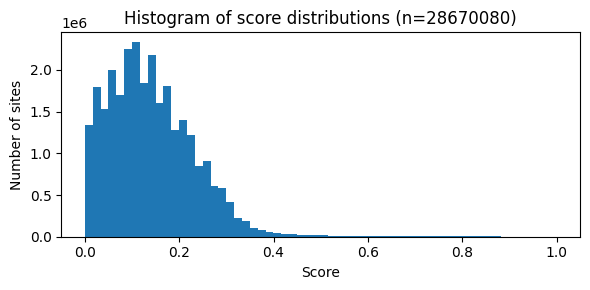

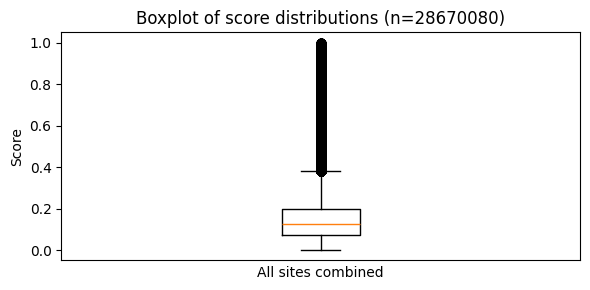

In [8]:
# Histogram of the scores
plt.figure(figsize=(6,3))
plt.hist(df['score'].dropna(), bins=60, density=False)
plt.title(f'Histogram of score distributions (n={len(df)})')
plt.xlabel('Score'); plt.ylabel('Number of sites')
plt.tight_layout()
plt.show()

# Boxplot of the scores
plt.figure(figsize=(6,3))
plt.boxplot([df['score'].dropna()])
plt.title(f'Boxplot of score distributions (n={len(df)})')
plt.ylabel('Score')
plt.xticks(ticks=[])
plt.xlabel('All sites combined')
plt.tight_layout()
plt.show() # Display the boxplot

Based on the predicted score distributions, we pick 0.4 as the threshold for the prediction of m6A modification..

### Histogram of relative transcript position of modification

In [9]:
# get max transcript position within transcript id
df['max_position'] = df.groupby('transcript_id')['transcript_position'].transform('max')
# calculate relative positions
df['relative_pos'] = df['transcript_position'] / df['max_position']
df

,transcript_id,transcript_position,score,sequence,avg_dwell_time,sample,cell_line,site_id,max_position,relative_pos
0,ENST00000418539,108,0.178182,GAGACCC,0.007300,SGNex_A549_directRNA_replicate5_run1,a549,ENST00000418539_108,166,0.650602
1,ENST00000418539,139,0.080000,AAAACAA,0.005640,SGNex_A549_directRNA_replicate5_run1,a549,ENST00000418539_139,166,0.837349
2,ENST00000383898,75,0.116364,ATGACAC,0.006879,SGNex_A549_directRNA_replicate5_run1,a549,ENST00000383898_75,75,1.000000
3,ENST00000610460,78,0.221818,AGGACAC,0.006992,SGNex_A549_directRNA_replicate5_run1,a549,ENST00000610460_78,78,1.000000
4,ENST00000619779,78,0.250909,AGGACAC,0.002990,SGNex_A549_directRNA_replicate5_run1,a549,ENST00000619779_78,78,1.000000
...,...,...,...,...,...,...,...,...,...,...
28670075,R2_66_2,568,0.032727,CTGACCA,0.007652,SGNex_MCF7_directRNA_replicate4_run1,mcf7,R2_66_2_568,769,0.738622
28670076,R2_66_2,605,0.014545,CAAACCA,0.006304,SGNex_MCF7_directRNA_replicate4_run1,mcf7,R2_66_2_605,769,0.786736
28670077,R2_66_2,623,0.043636,AGGACAA,0.007957,SGNex_MCF7_directRNA_replicate4_run1,mcf7,R2_66_2_623,769,0.810143
28670078,R2_66_2,679,0.065455,AGAACCT,0.008732,SGNex_MCF7_directRNA_replicate4_run1,mcf7,R2_66_2_679,769,0.882965


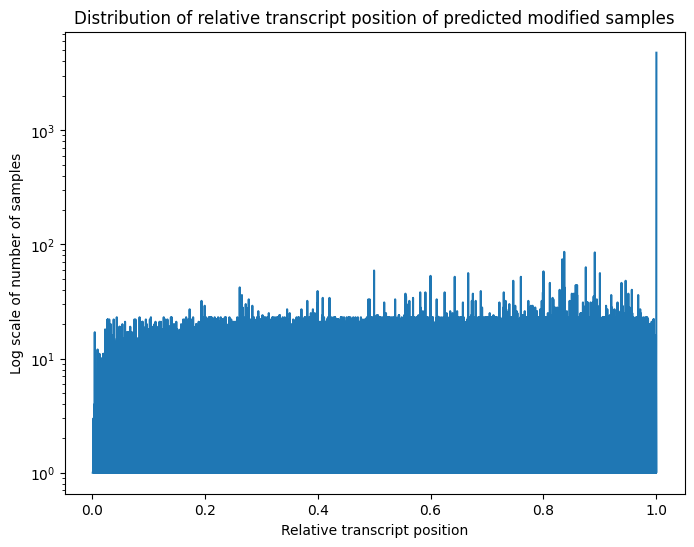

In [12]:
# plot the positional distribution of samples predicted to be modified
plot_data = df[df['score'] > 0.4].groupby('relative_pos').size()

plt.figure(figsize=(8,6))
plt.plot(plot_data.index, plot_data.values)
plt.yscale('log')
plt.xlabel('Relative transcript position')
plt.ylabel('Log scale of number of samples')
plt.title('Distribution of relative transcript position of predicted modified samples')
plt.show()

### Boxplot and histogram of average dwell time for modified and unmodified sites

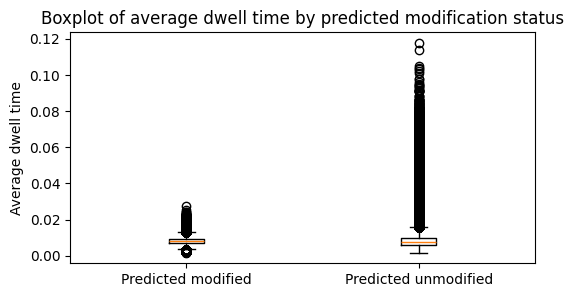

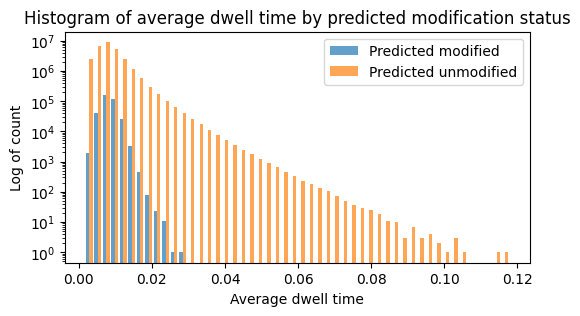

In [15]:
# Classify sites as modified if score > 0.4
df['pred_mod'] = df['score'] > 0.4

# Define groups for modified and unmodified sites
groups = [df.loc[df['pred_mod'], 'avg_dwell_time'].dropna().values, df.loc[~df['pred_mod'], 'avg_dwell_time'].dropna().values]

# Plot boxplot
plt.figure(figsize=(6, 3))
plt.boxplot(groups, tick_labels=['Predicted modified', 'Predicted unmodified'])
plt.ylabel('Average dwell time')
plt.title('Boxplot of average dwell time by predicted modification status')
plt.show()

# Plot histogram
plt.figure(figsize=(6, 3))
plt.hist(groups, label=['Predicted modified', 'Predicted unmodified'], bins=50, alpha=0.7)
plt.yscale('log')
plt.legend()
plt.xlabel('Average dwell time')
plt.ylabel('Log of count')
plt.title('Histogram of average dwell time by predicted modification status')
plt.show()

### Unique sites within each cell line

Per-cell line summary:


,cell_line,n_samples,n_sites,mean_score,median_score
0,a549,2,1632577,0.143479,0.130909
1,h9,6,2033651,0.144348,0.134545
2,hct116,3,1963526,0.144398,0.130909
3,hepg2,2,1879601,0.137481,0.123636
4,heya8,5,1941929,0.139592,0.127273
5,k562,3,1559321,0.142873,0.130909
6,mcf7,2,2698639,0.140377,0.127273


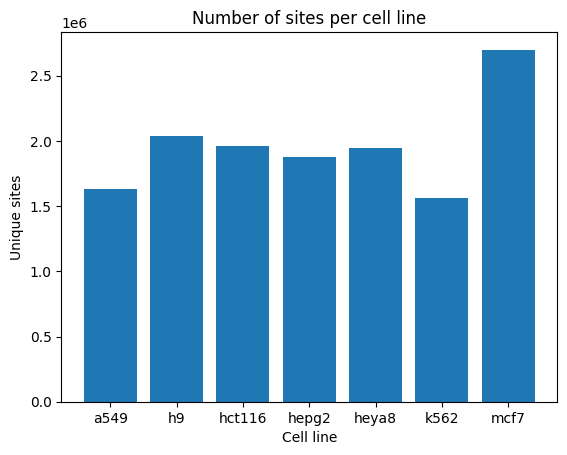

In [16]:
# Compute per-cell line statistics for all sites
summary = (
    df.groupby('cell_line')
    .agg(
        n_samples=('sample', 'nunique'), # number of rep/run for each cell line
        n_sites=('site_id', 'nunique'), # number of sites for each cell line
        mean_score=('score', 'mean'),
        median_score=('score', 'median')
    )
    .reset_index()
)

print("Per-cell line summary:")
display(summary)

# Bar plot of number of unique sites per cell line
plt.bar(summary['cell_line'], summary['n_sites'])
plt.title("Number of sites per cell line")
plt.xlabel("Cell line")
plt.ylabel("Unique sites")
plt.show()

Combined summary:


,cell_line,n_samples_all,n_sites_all,mean_score_all,median_score_all,n_samples_modified,n_sites_modified,mean_score_modified,median_score_modified,ratio_modified
0,a549,2,1632577,0.143479,0.130909,2,24247,0.544261,0.504135,0.014852
1,h9,6,2033651,0.144348,0.134545,6,30296,0.538183,0.494392,0.014897
2,hct116,3,1963526,0.144398,0.130909,3,43817,0.573072,0.518358,0.022315
3,hepg2,2,1879601,0.137481,0.123636,2,36241,0.555073,0.512720,0.019281
4,heya8,5,1941929,0.139592,0.127273,5,36086,0.548513,0.505382,0.018583
5,k562,3,1559321,0.142873,0.130909,3,19753,0.543819,0.498182,0.012668
6,mcf7,2,2698639,0.140377,0.127273,2,31021,0.550260,0.505357,0.011495


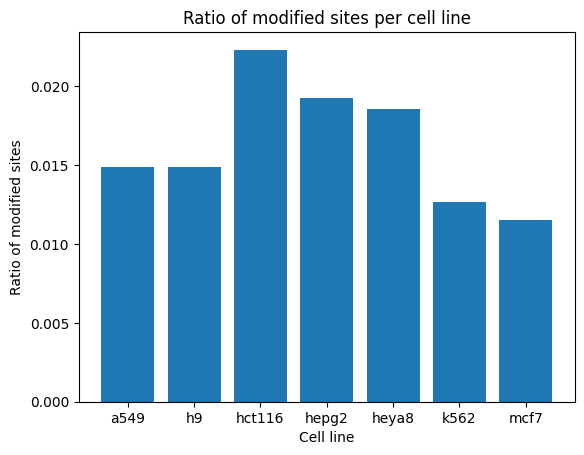

In [19]:
# Compute per-cell line statistics for modified sites only
summary_modified = (
    df[df['score'] > 0.4].groupby('cell_line') # only predicted modified sites
    .agg(
        n_samples=('sample', 'nunique'),
        n_sites=('site_id', 'nunique'),
        mean_score=('score', 'mean'),
        median_score=('score', 'median')
    )
    .reset_index()
)

# Merge back to all sites summary
summary_combined = summary.merge(summary_modified, on='cell_line', how='left', suffixes=('_all', '_modified'))
# Compute ratio of modified sites to total sites
summary_combined['ratio_modified'] = summary_combined['n_sites_modified'] / summary_combined['n_sites_all']

print("Combined summary:")
display(summary_combined)

# Bar plot of ratio of modified sites per cell line
plt.bar(summary_combined['cell_line'], summary_combined['ratio_modified'])
plt.title("Ratio of modified sites per cell line")
plt.xlabel("Cell line")
plt.ylabel("Ratio of modified sites")
plt.show()

### Shared vs cell line-specific sites

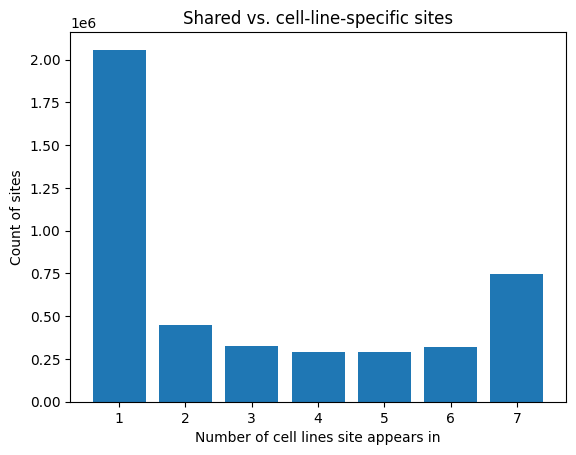

In [20]:
# Count how many cell lines each site appears in
site_counts = (
    df.groupby('site_id')['cell_line']
    .nunique()
    .value_counts()
    .sort_index()
)

# Bar plot of shared vs cell line-specific sites
plt.bar(site_counts.index, site_counts.values)
plt.title("Shared vs. cell-line-specific sites")
plt.xlabel("Number of cell lines site appears in")
plt.ylabel("Count of sites")
plt.show()

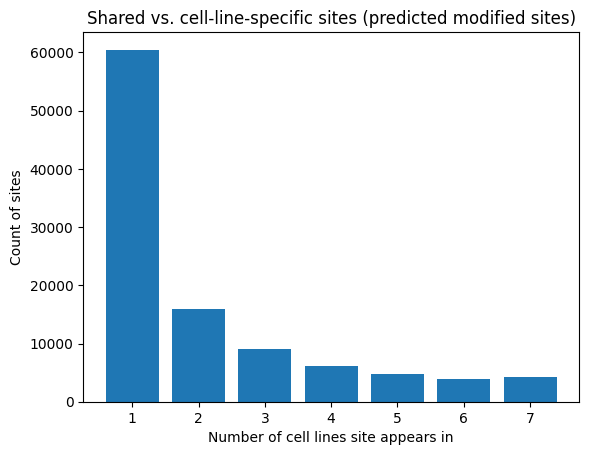

In [21]:
# Count how many cell lines each predicted modified site appears in
site_counts = (
    df[df['score'] > 0.4].groupby('site_id')['cell_line'] # only predicted modified sites
    .nunique()
    .value_counts()
    .sort_index()
)

plt.bar(site_counts.index, site_counts.values)
plt.title("Shared vs. cell-line-specific sites (predicted modified sites)")
plt.xlabel("Number of cell lines site appears in")
plt.ylabel("Count of sites")
plt.show()

### Spearman correlation of scores

In [23]:
# Pivot table for correlation
pivot = df.pivot_table(index='site_id', columns='sample', values='score')
corr = pivot.corr(method='spearman')
pivot

sample,SGNex_A549_directRNA_replicate5_run1,SGNex_A549_directRNA_replicate6_run1,SGNex_H9_directRNA_replicate2_run1,SGNex_H9_directRNA_replicate2_run2,SGNex_H9_directRNA_replicate3_run1,SGNex_H9_directRNA_replicate3_run2,SGNex_H9_directRNA_replicate4_run1,SGNex_H9_directRNA_replicate4_run2,SGNex_HEYA8_directRNA_replicate1_run1,SGNex_HEYA8_directRNA_replicate1_run2,...,SGNex_Hct116_directRNA_replicate3_run1,SGNex_Hct116_directRNA_replicate3_run4,SGNex_Hct116_directRNA_replicate4_run3,SGNex_HepG2_directRNA_replicate5_run2,SGNex_HepG2_directRNA_replicate6_run1,SGNex_K562_directRNA_replicate4_run1,SGNex_K562_directRNA_replicate5_run1,SGNex_K562_directRNA_replicate6_run1,SGNex_MCF7_directRNA_replicate3_run1,SGNex_MCF7_directRNA_replicate4_run1
site_id,,,,,,,,,,,,,,,,,,,,,
DQ459422_1063,NaN,NaN,NaN,NaN,NaN,NaN,0.152727,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DQ459422_363,NaN,NaN,NaN,NaN,NaN,NaN,0.101818,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DQ459422_407,NaN,NaN,NaN,NaN,NaN,NaN,0.178182,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DQ459422_472,NaN,NaN,NaN,NaN,NaN,NaN,0.265455,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DQ459422_517,NaN,NaN,NaN,NaN,NaN,NaN,0.116364,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SIRV8003_917,NaN,NaN,0.123636,0.127273,0.105455,NaN,0.101818,0.152727,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SIRV8003_932,NaN,NaN,NaN,0.101818,0.050909,NaN,0.109091,0.087273,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SIRV8003_941,NaN,NaN,0.189091,0.218182,0.243636,NaN,0.203636,0.189091,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


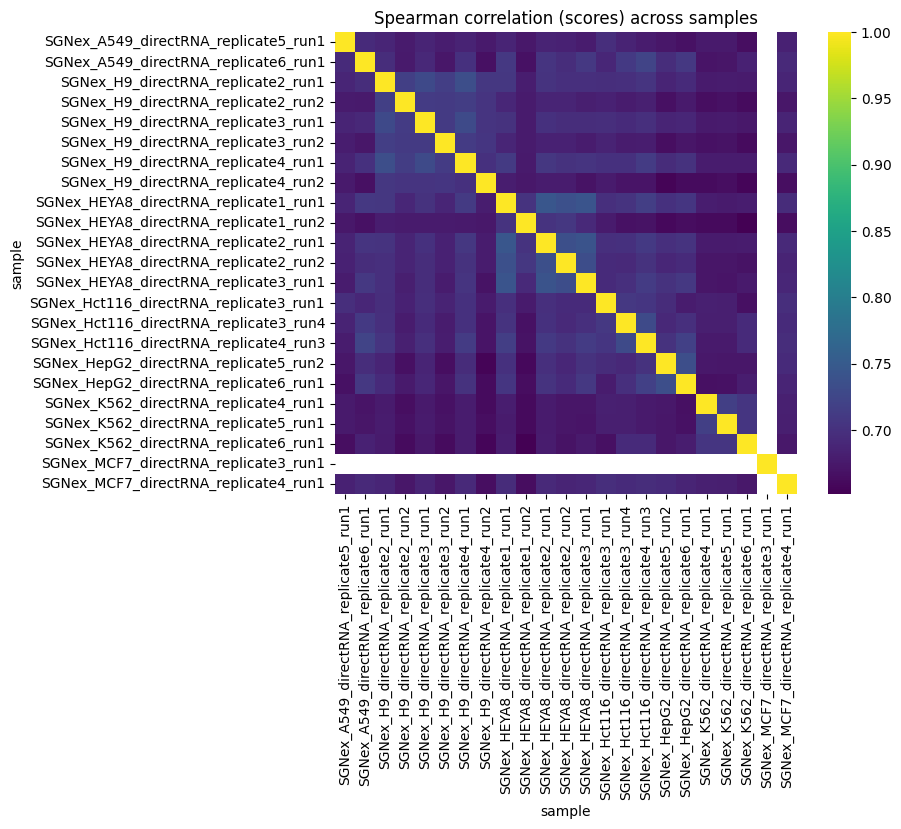

In [ ]:
# Plot heatmap of Spearman correlation
plt.figure(figsize=(8, 6))
sns.heatmap(corr, cmap='viridis', square=True)
plt.title("Spearman correlation (scores) across samples")
plt.show()

### PCA analysis of transcript and score data

In [ ]:
# Fill NaN values with 0 for PCA
pivot_pca = pivot.fillna(0)

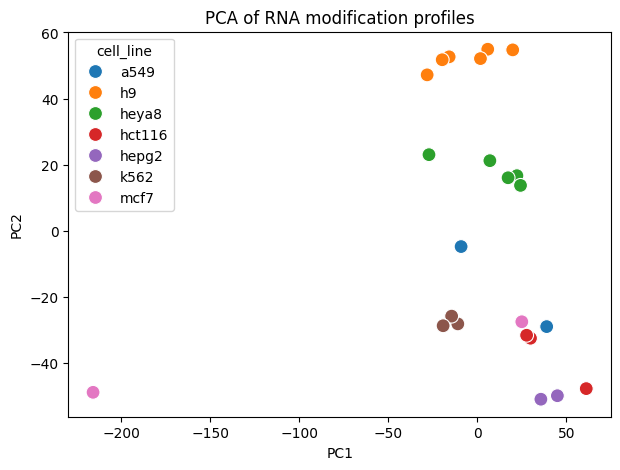

In [75]:
pca = PCA(n_components=2)
pcs = pca.fit_transform(pivot_pca.T)

pc_df = pd.DataFrame(pcs, columns=['PC1', 'PC2'], index=pivot_pca.columns)
pc_df['cell_line'] = pc_df.index.str.split('_').str[1].str.lower()

plt.figure(figsize=(7,5))
sns.scatterplot(data=pc_df, x='PC1', y='PC2', hue='cell_line', s=100)
plt.title('PCA of RNA modification profiles')
plt.show()

### Transcripts with highest mean predicted score and most predicted modified sites

In [88]:
# Identify top 10 transcripts with highest mean predicted score across all cell lines and all sites
top_transcripts = (
    df.groupby('transcript_id')['score']
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
    .rename(columns={'score': 'mean_score'})
)
print("Top 10 transcripts with highest mean predicted score (across all cell lines):")
display(top_transcripts)

Top 10 transcripts with highest mean predicted score (across all cell lines):


,transcript_id,mean_score
0,ENST00000530167,0.447792
1,ENST00000530167.1,0.444861
2,ENST00000312579,0.437117
3,ENST00000340958.3,0.424185
4,ENST00000312579.3,0.413169
5,ENST00000571757.1,0.409913
6,ENST00000548577,0.407614
7,ENST00000413079,0.400000
8,ENST00000553176.1,0.396364
9,ENST00000395145.3,0.381719


In [87]:
# Identify top 10 transcripts with highest mean predicted score across all cell lines but only for predicted modified sites
top_transcripts_modified = (
    df[df['score'] > 0.4].groupby('transcript_id')['score'] # only predicted modified sites
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
    .rename(columns={'score': 'mean_predicted_score'})
)

print("Top 10 transcripts with highest mean predicted score (predicted modified sites):")
display(top_transcripts_modified)

# Identify top 10 transcripts with highest number of predicted modified sites across all cell lines
top_transcripts_modified_counts = (
    df[df['score'] > 0.4].groupby('transcript_id')['score'] # only predicted modified sites
    .count()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
    .rename(columns={'score': 'number_of_predicted_modified_sites'})
)

print("Top 10 transcripts with highest number of predicted modified sites:")
display(top_transcripts_modified_counts)

Top 10 transcripts with highest mean predicted score (predicted modified sites):


,transcript_id,mean_predicted_score
0,ENST00000614867.2,0.960197
1,ENST00000188376.9,0.947542
2,ENST00000248879.7,0.947296
3,ENST00000205402.9,0.946322
4,ENST00000354321.11,0.938083
5,ENST00000593829.5,0.933812
6,ENST00000339083.11,0.921989
7,ENST00000540759.6,0.920954
8,ENST00000262225.7,0.919952
9,ENST00000490569.5,0.918861


Top 10 transcripts with highest number of predicted modified sites:


,transcript_id,number_of_predicted_modified_sites
0,ENST00000261622,373
1,ENST00000378024,290
2,ENST00000542575,283
3,ENST00000339647,280
4,ENST00000299238,276
5,ENST00000243253,267
6,ENST00000318560,259
7,ENST00000311922,253
8,ENST00000565644,253
9,ENST00000373812,252


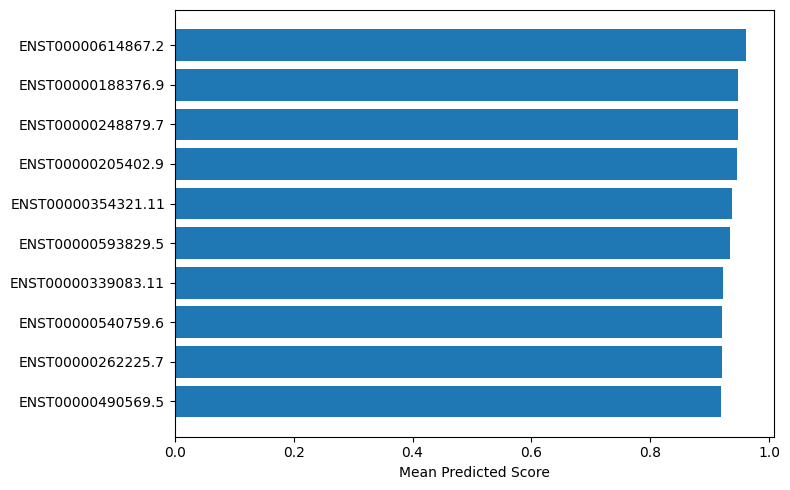

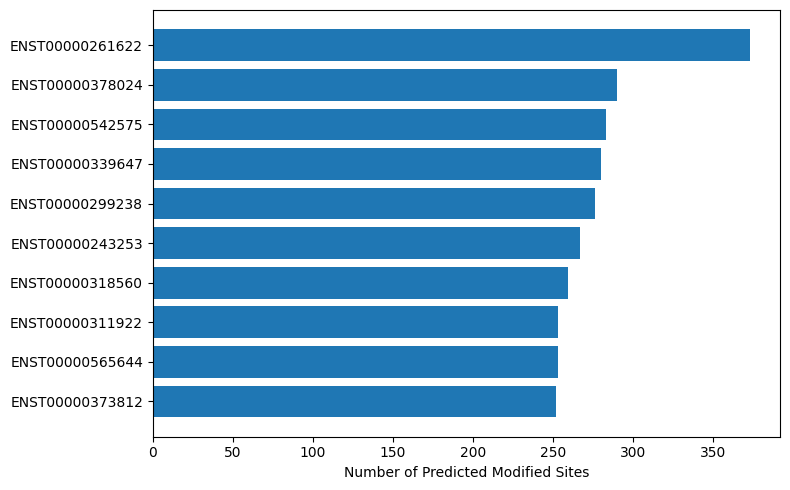

In [95]:
# Bar plot of top 10 transcripts with highest mean predicted score across all cell lines for predicted modified sites
plt.figure(figsize=(8,5))
plt.barh(top_transcripts_modified['transcript_id'], top_transcripts_modified['mean_predicted_score'])
plt.gca().invert_yaxis()
plt.xlabel('Mean Predicted Score')
plt.tight_layout()
plt.show()

# Bar plot of top 10 transcripts with highest number of predicted modified sites
plt.figure(figsize=(8,5))
plt.barh(top_transcripts_modified_counts['transcript_id'], top_transcripts_modified_counts['number_of_predicted_modified_sites'])
plt.gca().invert_yaxis()
plt.xlabel('Number of Predicted Modified Sites')
plt.tight_layout()
plt.show()

### Gene analysis

In [96]:
mg = mygene.MyGeneInfo()

# Extract unique ENST transcript IDs
# Keep the version number for the query
transcripts = df['transcript_id'].unique().tolist()

# Query mygene.info, explicitly requesting fields
query_results = mg.querymany(transcripts, scopes='ensembl.transcript', fields='symbol,name', species='human', returnall=True)

# Convert to DataFrame and handle missing fields
# Use the 'out' key from returnall=True which contains the results
query_df = pd.DataFrame(query_results['out'])

# Select and rename columns, safely handling potential missing columns
gene_map = query_df[['query','symbol','name']].copy()
gene_map.rename(columns={'query':'transcript_id'}, inplace=True)

# Handle cases where 'symbol' or 'name' might be lists or missing
for col in ['symbol', 'name']:
    if col in gene_map.columns:
        # For cases where mygene returns a list of symbols/names, take the first one
        gene_map[col] = gene_map[col].apply(lambda x: x[0] if isinstance(x, list) else x)
    else:
        # If the column is entirely missing, add it with None
        gene_map[col] = None

display(gene_map.head())

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
56 input query terms found dup hits:	[('ENST00000619779', 10), ('ENST00000621924', 2), ('ENST00000619488', 2), ('ENST00000625153', 3), ('
49300 input query terms found no hit:	['ENST00000503568', 'ENST00000588041', 'ENST00000602684', 'ENST00000510562', 'ENST00000607956', 'ENS


,transcript_id,symbol,name
0,ENST00000418539,BCYRN1,brain cytoplasmic RNA 1
1,ENST00000383898,RNU6-1,"RNA, U6 small nuclear 1"
2,ENST00000610460,RNA5-8SP10,"RNA, 5.8S ribosomal pseudogene 10"
3,ENST00000619779,LOC124908527,5.8S ribosomal RNA
4,ENST00000619779,LOC124907114,5.8S ribosomal RNA


In [97]:
gene_map

,transcript_id,symbol,name
0,ENST00000418539,BCYRN1,brain cytoplasmic RNA 1
1,ENST00000383898,RNU6-1,"RNA, U6 small nuclear 1"
2,ENST00000610460,RNA5-8SP10,"RNA, 5.8S ribosomal pseudogene 10"
3,ENST00000619779,LOC124908527,5.8S ribosomal RNA
4,ENST00000619779,LOC124907114,5.8S ribosomal RNA
...,...,...,...
144672,ENST00000550420,NaN,NaN
144673,ENST00000582299,AGAP7P,"ArfGAP with GTPase domain, ankyrin repeat and ..."
144674,ENST00000435593,NaN,NaN
144675,ENST00000397487,POTEKP,"POTE ankyrin domain family member K, pseudogene"


In [98]:
# Merge gene symbols into original df
df_all = df.merge(gene_map[['transcript_id', 'symbol', 'name']], on='transcript_id', how='left')

# Summarise per gene and cell line
gene_summary = (
    df_all.groupby(['cell_line', 'symbol'])
    .agg(mean_score=('score', 'mean'), n_sites=('site_id', 'nunique'))
    .reset_index()
)

display(gene_summary.head())

,cell_line,symbol,mean_score,n_sites
0,a549,A1BG,0.189870,21
1,a549,A1BG-AS1,0.168537,48
2,a549,A2M-AS1,0.168221,23
3,a549,A4GALT,0.195646,92
4,a549,AAAS,0.135127,86


Index(['CCDC85B', 'TMEM203', 'SF3B5', 'LINC02538', 'H2AX', 'HES3', 'CERS3',
       'IMP3', 'CEBPB', 'PRLHR', 'SERPINB9P1', 'PRSS8', 'LINC02277', 'HPS6',
       'IGLV7-46'],
      dtype='object', name='symbol')

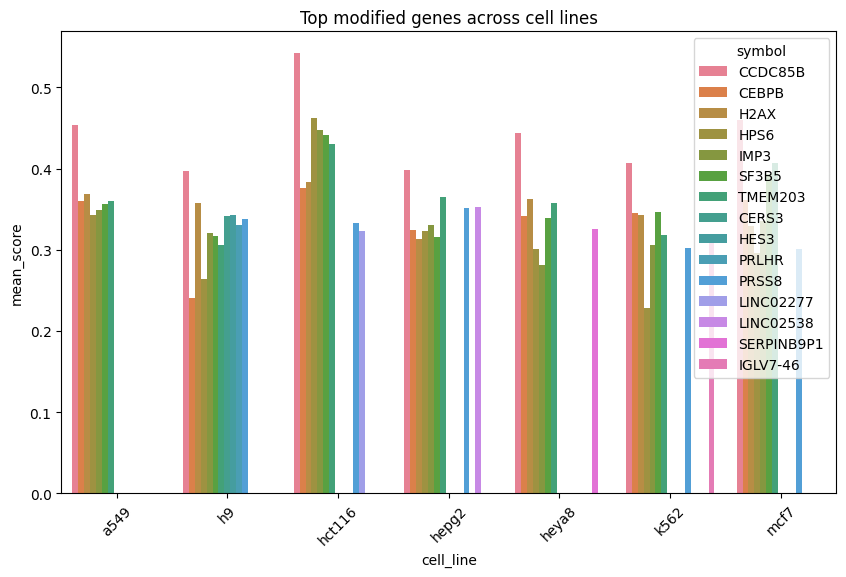

In [100]:
# Get the genes with top mean scores for each cell line
top_genes = (
    gene_summary.groupby('symbol')['mean_score']
    .mean()
    .sort_values(ascending=False)
    .head(15)
    .index
)

display(top_genes)

# Plot the top genes for each cell line
plt.figure(figsize=(10,6))
sns.barplot(data=gene_summary[gene_summary['symbol'].isin(top_genes)], x='cell_line', y='mean_score', hue='symbol')
plt.title('Top modified genes across cell lines')
plt.xticks(rotation=45)
plt.show()